## Assignment 2

# 2. Dataset description and Overview
The dataset used for this assignment is a sample from [EMNIST handwritten character dataset - ByClass](https://www.nist.gov/itl/products-and-services/emnist-dataset), a collection of 814,255+ 28 by 28 images with character labels. This smaller sample set can be downloaded from the Google Drive link provided in the assignment specification. The dataset consists of 120000 amount images, of which 100,000 is split into a test set, which was further divided into a validation set after pre-processing, and a testing set of 20,000.

In [3]:
!pip install numpy
!pip install matplotlib
!pip install tensorflow
!pip install scikit-learn
!pip install scipy==1.12
!pip install torch
!pip install torchvision
!pip install tqdm
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import keras
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from torchvision import transforms
from torchvision.models import resnet18, resnet50
from torchvision.models.vision_transformer import vit_b_16
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import ReLU
from torchsummary import summary

In [5]:
train_dict = pickle.load(open('emnist_train.pkl', 'rb'))
test_dict = pickle.load(open('emnist_test.pkl', 'rb'))

# Extract the images and labels from the dictionaries
train_images = train_dict['data']
train_labels = train_dict['labels']
test_images = test_dict['data']
test_labels = test_dict['labels']
print("Testing images shape:", test_images.shape)
print("Training images shape:", train_images.shape)


Testing images shape: (20000, 28, 28)
Training images shape: (100000, 28, 28)


In [6]:


# # Number of images to display
# num_images = 10

# # Create a figure and axes for the grid
# fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# # Iterate through the sample images
# for i in range(num_images):
#     # Select a random image
#     random_index = np.random.randint(0, len(train_images))
#     image = train_images[random_index].reshape(28, 28)

#     # Convert the NumPy array to a PIL image
#     pil_image = Image.fromarray((image * 255))  # Convert to uint8 for PIL compatibility

#     # Rotate the image 90 degrees clockwise
#     rotated_image = pil_image.rotate(-90).transpose(Image.FLIP_LEFT_RIGHT) # Negative angle for clockwise rotation

#     # Convert back to NumPy array for displaying with matplotlib
#     rotated_image_np = np.array(rotated_image)

#     # Display the image
#     axes[i].imshow(rotated_image_np, cmap='gray')
#     axes[i].axis('off')

# plt.show()


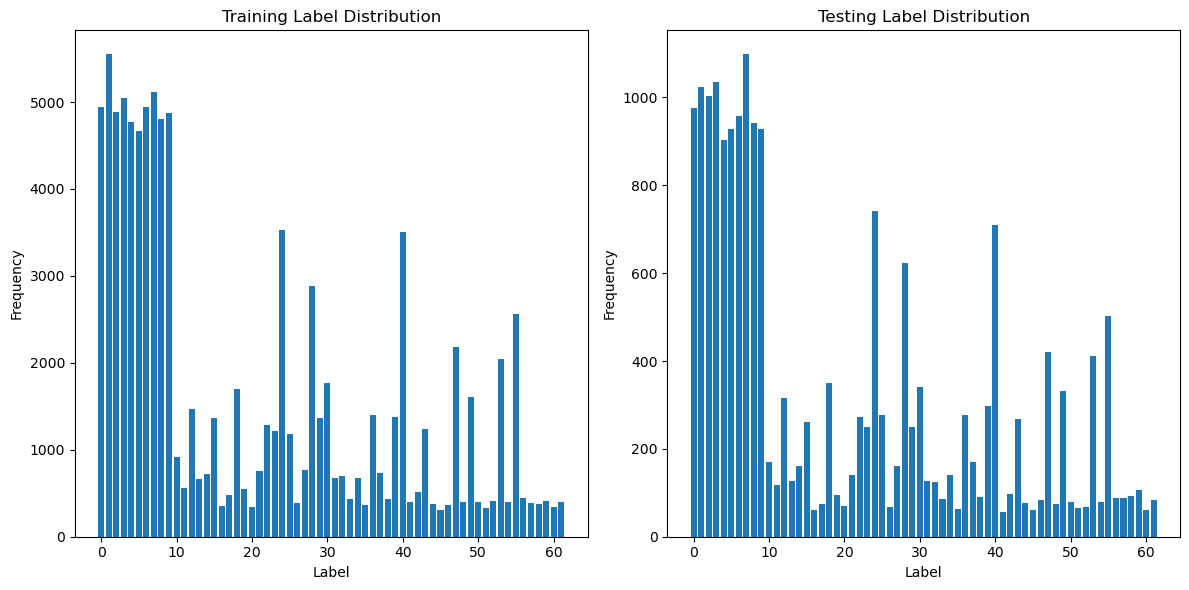

In [7]:
# Calculate the frequency of each label in the training set
train_label_counts = {}
for label in train_labels:
  if label not in train_label_counts:
    train_label_counts[label] = 0
  train_label_counts[label] += 1
# Calculate the frequency of each label in the testing set
test_label_counts = {}
for label in test_labels:
  if label not in test_label_counts:
    test_label_counts[label] = 0
  test_label_counts[label] += 1

def display_data_distribution(train_labels, test_labels):

  # Plot the histogram of training labels
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.bar(train_labels.keys(), train_labels.values())
  plt.title('Training Label Distribution')
  plt.xlabel('Label')
  plt.ylabel('Frequency')

  # Plot the histogram of testing labels
  plt.subplot(1, 2, 2)
  plt.bar(test_labels.keys(), test_labels.values())
  plt.title('Testing Label Distribution')
  plt.xlabel('Label')
  plt.ylabel('Frequency')

  plt.tight_layout()
  plt.show()

display_data_distribution(train_label_counts, test_label_counts)


# 3. Data Preparation

Requred data is provided in a folder that contains a .mat file which is to be loaded in and then XXXX

The folder includes:

Folder details


## 3.1 Merging Classes

Due to the similarities of Uppercase and Lowercase letters, as suggested by the dataset specific images will be merged, for example lowercase 'k' is similar to uppercase "K"

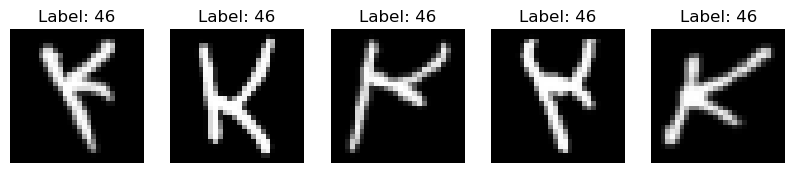

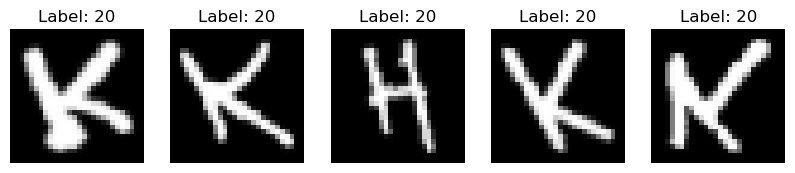

In [8]:
def display_images_by_label(images, labels, target_label, num_samples=5):
    # Find the indices of images with the target label
    indices = np.where(labels == target_label)[0]

    # Display a few images with the specified label
    if len(indices) == 0:
        print(f"No images found for label {target_label}")
        return

    # Limit to the specified number of samples
    indices = indices[:num_samples]

    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        rotated_image = np.rot90(images[idx].reshape(28, 28), k=1)

        # Display the rotated image
        plt.imshow(rotated_image, cmap='gray')
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.show()

# Example usage:
# For example, 38 is 'c' and 12 is 'C' in the original EMNIST ByClass labels.
display_images_by_label(train_images, train_labels, target_label=46, num_samples=5)  # Display lowercase 'c'
display_images_by_label(train_images, train_labels, target_label=20, num_samples=5)  # Display uppercase 'C'

In [9]:
merge_dictionary = {
        38: 12,  # 'c' -> 'C'
        44: 18,  # 'i' -> 'I'
        45: 19,  # 'j' -> 'J'
        46: 20,  # 'k' -> 'K'
        47: 21,  # 'l' -> 'L'
        48: 22,  # 'm' -> 'M'
        50: 24,  # 'o' -> 'O'
        51: 25,  # 'p' -> 'P'
        54: 28,  # 's' -> 'S'
        56: 30,  # 'u' -> 'U'
        57: 31,  # 'v' -> 'V'
        58: 32,  # 'w' -> 'W'
        59: 33,  # 'x' -> 'X'
        60: 34,  # 'y' -> 'Y'
        61: 35   # 'z' -> 'Z'
    }

def merge_labels(labels, merge_dictionary):
    merged_labels = np.copy(labels)
    for old_label, new_label in merge_dictionary.items():
        merged_labels[labels == old_label] = new_label
    return merged_labels

#Step 0
# Merge the labels
train_labels = merge_labels(train_labels, merge_dictionary)
test_labels = merge_labels(test_labels, merge_dictionary)
#Print Number of unique labels
print("Number of unique labels in the training set:", len(np.unique(train_labels)))
print("Number of unique labels in the testing set:", len(np.unique(test_labels)))

Number of unique labels in the training set: 47
Number of unique labels in the testing set: 47


In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)


# Step 1: Normalize the pixel values (0-255) to the range [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Step 2: Reshape the images for model input
N_train = train_images.shape[0]  # Number of training images
N_test = test_images.shape[0]    # Number of testing images

# Reshape the images to (N, 28, 28, 1)
train_images = train_images.reshape(N_train, 28, 28, 1)
test_images = test_images.reshape(N_test, 28, 28, 1)

# Step 2.5 Validation set
X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_labels, train_size=0.9, random_state=42)

# Step 3: Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=10,       # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,   # Randomly shift images horizontally by up to 10% of width
    height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of height
    zoom_range=0.1           # Randomly zoom into images by up to 10%
)

# No augmentation for validation data, just rescaling
valid_datagen = ImageDataGenerator()

# Fit the data generator on the training images
train_datagen.fit(X_train)


# Step 4.5: Class Rebalancing
# Compute class weights to account for class imbalance
classes = np.unique(y_train)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Summary of preprocessing steps
print("Train images shape (after reshaping):", X_train.shape)
print("Validation images shape:", X_valid.shape)
print("Test images shape (after reshaping):", test_images.shape)
print("Class weights for balancing:", class_weights_dict)

Train images shape (after reshaping): (90000, 28, 28, 1)
Validation images shape: (10000, 28, 28, 1)
Test images shape (after reshaping): (20000, 28, 28, 1)
Class weights for balancing: {0: 0.42954096388992297, 1: 0.38251969976453787, 2: 0.4321583428168081, 3: 0.421968624288514, 4: 0.45098766298193044, 5: 0.4541967782308531, 6: 0.43235349221523517, 7: 0.414120591916366, 8: 0.44357044637972587, 9: 0.43372448856654056, 10: 2.33523611831863, 11: 3.732736095558044, 12: 1.1283993028999861, 13: 3.223726627981947, 14: 2.9459901800327333, 15: 1.5695849319846529, 16: 5.946874587022598, 17: 4.474050507059057, 18: 1.0234599770290094, 19: 2.486874827300359, 20: 3.0638297872340425, 21: 0.7206976353109811, 22: 1.2673021952490249, 23: 1.736077621959453, 24: 0.5440038684719536, 25: 1.435452486522696, 26: 5.733214422219391, 27: 2.7711919204360007, 28: 0.6502185456778529, 29: 1.5442690459849004, 30: 0.9603277918862972, 31: 2.015677491601344, 32: 1.9539730785931393, 33: 2.5772457833395377, 34: 2.11824515

In [32]:

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

        # Define the transformations: resize and convert to 3 channels
        self.transform = transforms.Compose([
            transforms.ToPILImage(),                    # Convert tensor to PIL Image
            transforms.Resize(224),                     # Resize image to 224x224 pixels
            transforms.Grayscale(num_output_channels=3),# Convert to 3 channels by duplicating the grayscale channel
            transforms.ToTensor()                       # Convert back to tensor
        ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Apply the transformations
        image = self.transform(image)

        return image, label

# # Create datasets with transforms
train_dataset = CustomDataset(train_images, train_labels)
test_dataset = CustomDataset(test_images, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [12]:
# Define and instantiate CNN

keras.backend.clear_session()

cnn = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),  # Input shape for EMNIST data

    # First Conv Block
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Second Conv Block
    keras.layers.Conv2D(48, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Third Conv Block
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),

    # Fourth Conv Block
    keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Flatten Layer
    keras.layers.Flatten(),

    # Fully Connected Layers
    keras.layers.Dense(128),  # No activation here, add as a separate layer
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(classes), activation="softmax"),  # Output layer for classification
])

cnn.summary()

I0000 00:00:1728708907.146813  588251 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728708907.147420  588251 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-12 15:55:07.154103: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 14, 14, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 288,031 (1.10 MB)

 Trainable params: 286,975 (1.09 MB)

 Non-trainable params: 1,056 (4.12 KB)

In [38]:
# Instantiate the Vision Transformer and Resnet 18
num_classes = len(np.unique(train_labels))
resnet = resnet18(num_classes, pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
print(resnet)

/home/calvin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/calvin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Compile model with adjusted learning rate for Adam optimizer
learning_rate = 0.0005  # Decreasing the learning rate for better convergence
optimizer = Adam(learning_rate=learning_rate)

cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Set batch size and number of epochs
batch_size = 128
epochs = 30

# Fit the model
history = cnn.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs, validation_data=valid_datagen.flow(X_valid, y_valid, batch_size=batch_size),
                    class_weight=class_weights_dict)

Epoch 1/30


/home/calvin/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 88s 113ms/step - accuracy: 0.4030 - loss: 2.3820 - val_accuracy: 0.8189 - val_loss: 0.5709
Epoch 2/30
413/704 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.7396 - loss: 0.7813

KeyboardInterrupt: 

In [35]:
vit = vit_b_16(pretrained=False)
vit.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=num_classes)
)

print(vit)


/home/calvin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/calvin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [40]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# Function to generate all combinations of hyperparameters
def generate_hyperparam_combinations(param_grid):
    keys, values = zip(*param_grid.items())
    return [dict(zip(keys, v)) for v in itertools.product(*values)]

def train_model(
    model, 
    train_loader, 
    test_loader, 
    train_labels, 
    class_weights_dict, 
    num_epochs=10, 
    learning_rate=0.0001, 
    optimizer_name='Adam', 
    momentum=0.9, 
    weight_decay=0.0, 
    scheduler_name=None, 
    step_size=5, 
    gamma=0.1, 
    patience=2
):
    # Set device (GPU if available)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Prepare class weights
    classes = np.unique(train_labels)
    class_weights_list = [class_weights_dict[cls] for cls in classes]
    class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float).to(device)

    # Define loss function with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    # Define optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # Define learning rate scheduler if provided
    if scheduler_name == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_name == 'ReduceLROnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience, factor=gamma)
    else:
        scheduler = None  # No scheduler by default

    # Training Loop with Progress Bar
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Update metrics
                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                pbar.update(1)
                pbar.set_postfix(loss=running_loss / total, accuracy=100.0 * correct / total)

        # Validation Loop (Calculate Test Accuracy, Precision, Recall after Each Epoch)
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        conf_matrix = confusion_matrix(all_labels, all_preds)

        print(f'Epoch [{epoch+1}/{num_epochs}] Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}')

        # Step the scheduler if available
        if scheduler_name == 'ReduceLROnPlateau':
            scheduler.step(running_loss / total)  # Step with validation loss
        elif scheduler:
            scheduler.step()

        model.train()

    # Calculate final metrics after all training epochs
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    final_test_accuracy = accuracy_score(all_labels, all_preds)
    final_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    final_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    final_conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f'Final Test Accuracy: {final_test_accuracy:.2f}, Precision: {final_precision:.2f}, Recall: {final_recall:.2f}')

    return {
        'final_test_accuracy': final_test_accuracy,
        'precision': final_precision,
        'recall': final_recall,
        'confusion_matrix': final_conf_matrix
    }



In [41]:
# Train resnet

train_model(model=resnet, train_loader=train_loader, test_loader=test_loader, train_labels=train_labels, class_weights_dict=class_weights_dict, num_epochs=10, learning_rate=5e-5)

Epoch [1/10]: 100%|██████████| 3125/3125 [06:57<00:00,  7.48batch/s, accuracy=88.3, loss=0.284]


Epoch [1/10] Accuracy: 0.87, Precision: 0.89, Recall: 0.87


Epoch [2/10]: 100%|██████████| 3125/3125 [07:43<00:00,  6.74batch/s, accuracy=89.4, loss=0.24] 


Epoch [2/10] Accuracy: 0.88, Precision: 0.90, Recall: 0.88


Epoch [3/10]: 100%|██████████| 3125/3125 [07:47<00:00,  6.69batch/s, accuracy=90.1, loss=0.208]


Epoch [3/10] Accuracy: 0.89, Precision: 0.90, Recall: 0.89


Epoch [4/10]: 100%|██████████| 3125/3125 [07:43<00:00,  6.74batch/s, accuracy=90.9, loss=0.182]


Epoch [4/10] Accuracy: 0.90, Precision: 0.90, Recall: 0.90


Epoch [5/10]: 100%|██████████| 3125/3125 [07:44<00:00,  6.72batch/s, accuracy=91.5, loss=0.159]


Epoch [5/10] Accuracy: 0.90, Precision: 0.91, Recall: 0.90


Epoch [6/10]: 100%|██████████| 3125/3125 [07:42<00:00,  6.76batch/s, accuracy=92.2, loss=0.135]


Epoch [6/10] Accuracy: 0.89, Precision: 0.90, Recall: 0.89


Epoch [7/10]: 100%|██████████| 3125/3125 [07:11<00:00,  7.24batch/s, accuracy=92.9, loss=0.12] 


Epoch [7/10] Accuracy: 0.90, Precision: 0.90, Recall: 0.90


Epoch [8/10]: 100%|██████████| 3125/3125 [06:57<00:00,  7.48batch/s, accuracy=93.4, loss=0.107] 


Epoch [8/10] Accuracy: 0.90, Precision: 0.90, Recall: 0.90


Epoch [9/10]: 100%|██████████| 3125/3125 [06:18<00:00,  8.26batch/s, accuracy=93.9, loss=0.0942]


Epoch [9/10] Accuracy: 0.90, Precision: 0.90, Recall: 0.90


Epoch [10/10]: 100%|██████████| 3125/3125 [07:15<00:00,  7.17batch/s, accuracy=94.5, loss=0.0838]


Epoch [10/10] Accuracy: 0.90, Precision: 0.90, Recall: 0.90
Final Test Accuracy: 0.90, Precision: 0.90, Recall: 0.90


{'final_test_accuracy': 0.89745,
 'precision': 0.8993416157920888,
 'recall': 0.89745,
 'confusion_matrix': array([[623,   0,   0, ...,   0,   0,   0],
        [  0, 713,   1, ...,   0,   0,   1],
        [  0,   0, 974, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  28,   0,   0],
        [  0,   0,   0, ...,   1, 390,   0],
        [  0,   0,   0, ...,   0,   3, 476]])}